In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json

import sys

sys.path.append("../../")

##################################################################
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "1,2,3,4,5,6,7"
##################################################################

import logging
from src.utils import logging_utils
from src.utils import env_utils

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(
    f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}"
)
logger.info(f"{transformers.__version__=}")

2025-09-10 16:50:47 __main__ INFO     torch.__version__='2.7.0+cu126', torch.version.cuda='12.6'
2025-09-10 16:50:48 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=7, torch.cuda.get_device_name()='NVIDIA A100 80GB PCIe'
2025-09-10 16:50:48 __main__ INFO     transformers.__version__='4.55.3'


In [3]:
from src.utils.training_utils import get_device_map

# model_key = "meta-llama/Llama-3.2-3B"
# model_key = "meta-llama/Llama-3.1-8B"
# model_key = "meta-llama/Llama-3.1-70B-Instruct"
model_key = "meta-llama/Llama-3.3-70B-Instruct"
# model_key = "meta-llama/Llama-3.1-405B-Instruct"

# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-3-12b-it"
# model_key = "google/gemma-2-27b-it"

# model_key = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

# model_key = "allenai/OLMo-2-1124-7B-Instruct"
# model_key = "allenai/OLMo-7B-0424-hf"

# model_key = "Qwen/Qwen2-7B"
# model_key = "Qwen/Qwen2.5-14B-Instruct"
# model_key = "Qwen/Qwen2.5-32B-Instruct"
# model_key = "Qwen/Qwen2.5-72B-Instruct"

# model_key = "Qwen/Qwen3-1.7B"
# model_key = "Qwen/Qwen3-4B"
# model_key = "Qwen/Qwen3-8B"
# model_key = "Qwen/Qwen3-14B"
# model_key = "Qwen/Qwen3-32B"

# device_map = get_device_map(model_key, 30, n_gpus=8)
# device_map

2025-09-10 16:50:50 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks/checking_head_generalization, stdin=None, shell=False, universal_newlines=False)
2025-09-10 16:50:50 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks/checking_head_generalization, stdin=None, shell=False, universal_newlines=False)
2025-09-10 16:50:50 wandb.docker.auth DEBUG    Trying paths: ['/disk/u/arnab/.docker/config.json', '/disk/u/arnab/.dockercfg']
2025-09-10 16:50:50 wandb.docker.auth DEBUG    No config file found


In [4]:
from src.models import ModelandTokenizer

# from transformers import BitsAndBytesConfig

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.bfloat16,
    # device_map=device_map,
    device_map="auto",
    # quantization_config = BitsAndBytesConfig(
    #     # load_in_4bit=True
    #     load_in_8bit=True
    # )
    attn_implementation="eager",
)

2025-09-10 16:50:51 src.models WARNING  meta-llama/Llama-3.3-70B-Instruct not found in /disk/u/arnab/Codes/Models
If not found in cache, model will be downloaded from HuggingFace to cache directory
2025-09-10 16:50:51 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:443


2025-09-10 16:50:51 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/config.json HTTP/1.1" 200 0
2025-09-10 16:50:51 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2025-09-10 16:50:52 urllib3.connectionpool DEBUG    https://huggingface.co:443 "GET /api/models/meta-llama/Llama-3.3-70B-Instruct/tree/main/additional_chat_templates?recursive=False&expand=False HTTP/1.1" 404 64


Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

2025-09-10 16:51:37 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/generation_config.json HTTP/1.1" 200 0
2025-09-10 16:51:37 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/custom_generate/generate.py HTTP/1.1" 404 0
2025-09-10 16:51:38 src.models INFO     loaded model <meta-llama/Llama-3.3-70B-Instruct> | size: 134570.516 MB | dtype: torch.bfloat16 | device: cuda:0


In [5]:
from src.selection.data import SelectOneTask, CountingTask

#################################################################################
TASK_CLS = SelectOneTask
prompt_template_idx = 3
N_DISTRACTORS = 5
OPTION_STYLE = "single_line"
#################################################################################

select_task = TASK_CLS.load(
    path=os.path.join(
        env_utils.DEFAULT_DATA_DIR, 
        "selection", 
        # "profession.json"
        # "nationality.json"
        "objects.json"
    )
)

print(select_task)

SelectOneTask: (different objects)
Categories: fruit(15), vehicle(15), furniture(15), animal(15), music instrument(15), clothing(15), electronics(15), sport equipment(15), kitchen appliance(15), vegetable(14), building(15), office supply(15), bathroom item(15), flower(15), tree(15), jewelry(15)



In [6]:
sample = select_task.get_random_sample(
    mt = mt,
    option_style=OPTION_STYLE,
    prompt_template_idx=prompt_template_idx,
    # category="actor",
    # category="Brazil"
    category="fruit",
    filter_by_lm_prediction=False,
)

print(sample.prompt(), ">>", f'"{mt.tokenizer.decode([sample.ans_token_id])}"')

Options: Kiwi, Rose, Food processor, Museum, Shampoo, Printer.
Which among these objects mentioned above is a fruit?
Answer: >> " Ki"


## Loading the heads

2025-09-10 16:51:38 matplotlib DEBUG    matplotlib data path: /disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/matplotlib/mpl-data
2025-09-10 16:51:38 matplotlib DEBUG    CONFIGDIR=/disk/u/arnab/.config/matplotlib
2025-09-10 16:51:38 matplotlib DEBUG    interactive is False
2025-09-10 16:51:38 matplotlib DEBUG    platform is linux
2025-09-10 16:51:38 matplotlib DEBUG    CACHEDIR=/disk/u/arnab/.cache/matplotlib
2025-09-10 16:51:38 matplotlib.font_manager DEBUG    Using fontManager instance from /disk/u/arnab/.cache/matplotlib/fontlist-v390.json
2025-09-10 16:51:38 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-09-10 16:51:38 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-09-10 16:51:38 matplotlib.font_manager DEBUG    findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-09-10 16:51:38 matplotlib.font

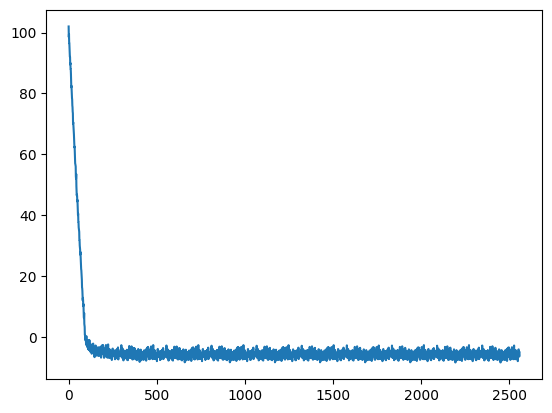

In [7]:
from matplotlib import pyplot as plt
import numpy as np

# optimized_path = os.path.join(
#     env_utils.DEFAULT_RESULTS_DIR,
#     "selection/optimized_backup_heads",
#     mt.name.split("/")[-1],
#     f"{select_task.task_name}.npz"
# )

optimized_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/optimized_heads",
    model_key.split("/")[-1],
    "distinct_options",
    # f"{select_task.task_name}",
    "select_one",
    # "legacy",
    "epoch_10.npz"
)

# optimized_path = os.path.join(
#     env_utils.DEFAULT_RESULTS_DIR,
#     "test_opt_code",
#     model_key.split("/")[-1],
#     "distinct_options",
#     f"{select_task.task_name}",
#     # "select_one",
#     "legacy",
#     "epoch_10.npz"
# )

optimization_results = np.load(optimized_path, allow_pickle=True)
plt.plot(optimization_results["losses"])
plt.show()

79


(True, True)

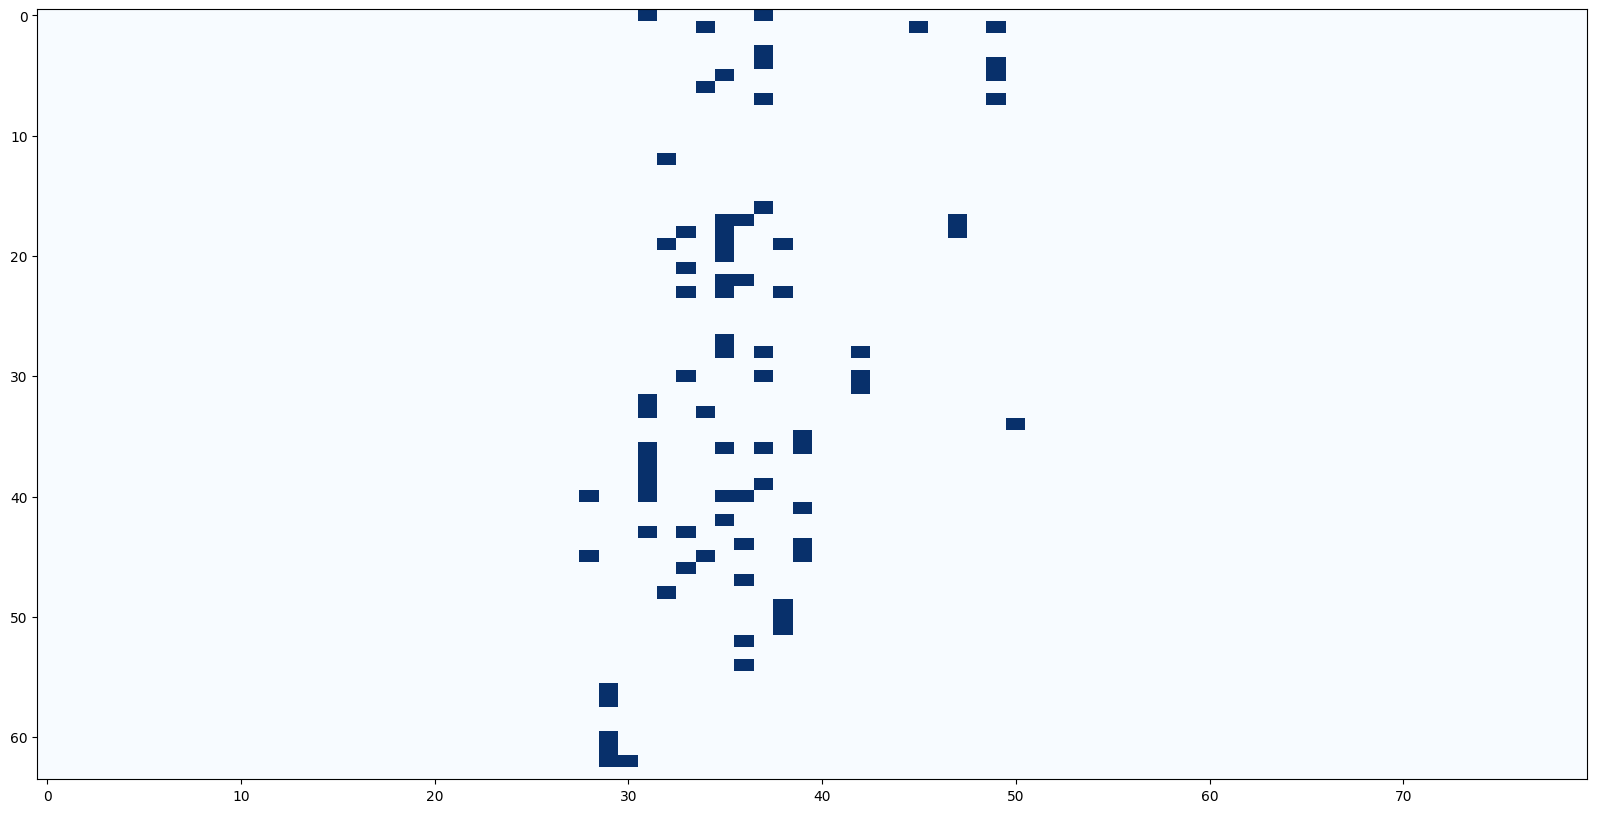

In [8]:
plt.figure(figsize=(20, 10))

optimal_head_mask = torch.tensor(optimization_results["optimal_mask"]).to(torch.float32)
optimal_head_mask[52:, :] = 0.0

plt.imshow(
    optimal_head_mask.T.numpy(),
    cmap="Blues",
    aspect="auto",
    vmin=0,
    vmax=1,
)

optimized_heads = torch.nonzero(optimal_head_mask > 0.5, as_tuple=False).tolist()
optimized_heads = [
    (layer_idx, head_idx) for layer_idx, head_idx in optimized_heads
]
print(len(optimized_heads))

HEADS = optimized_heads

(35, 19) in HEADS, (35, 19) in optimized_heads
# [(29, 3) in HEADS]

In [9]:
from src.attention import get_attention_matrices
from src.selection.functional import (
    verify_head_patterns,
    get_patches_to_verify_independent_enrichment,
)

attn_pattern = verify_head_patterns(
    prompt=sample.prompt(option_style="single_line"),
    options=sample.options,
    mt=mt,
    heads=optimized_heads,
    # heads = HEADS,
    # heads = [(35, 19)],
    start_from=1
)

2025-09-10 16:51:41 src.selection.functional DEBUG    Predictions: ['" Ki"[30558] (p=0.898, logit=22.625)', '" The"[578] (p=0.045, logit=19.625)', '" Among"[22395] (p=0.024, logit=19.000)', '" A"[362] (p=0.011, logit=18.250)', '" Fruit"[44187] (p=0.003, logit=16.875)']
2025-09-10 16:51:41 src.selection.functional INFO     Combined attention matrix for all heads


# Validating Against Other Reduce Tasks

## Yes_No Task

In [10]:
from src.selection.data import YesNoSample, YesNoTask

yes_no_task = YesNoTask.load(
    path=os.path.join(
        env_utils.DEFAULT_DATA_DIR, 
        "selection", 
        "objects.json"
    )
)
print(yes_no_task)

YesNoTask: (different objects)
Categories: fruit(15), vehicle(15), furniture(15), animal(15), music instrument(15), clothing(15), electronics(15), sport equipment(15), kitchen appliance(15), vegetable(14), building(15), office supply(15), bathroom item(15), flower(15), tree(15), jewelry(15)


In [11]:
test_sample = yes_no_task.get_random_sample(
    mt = mt,
    option_style=OPTION_STYLE,
    prompt_template_idx=3,
    category="fruit",
    yes_mode=True,
    filter_by_lm_prediction=True,
)
print(test_sample.prompt(), ">>", f'"{mt.tokenizer.decode([test_sample.ans_token_id])}"')
test_sample.prediction

Items: Carrot, Factory, Mango, Strawberry, Necklace
Do you see a fruit in the list above?
Answer: >> " Yes"


[PredictedToken(token=' Yes', prob=0.75390625, logit=20.375, token_id=7566, metadata=None),
 PredictedToken(token=' No', prob=0.0201416015625, logit=16.75, token_id=2360, metadata=None)]

In [12]:
attn_pattern = verify_head_patterns(
    prompt=test_sample.prompt(option_style="single_line"),
    options=test_sample.options,
    mt=mt,
    heads=optimized_heads,
    # heads = HEADS,
    # heads = [(35, 19)],
    start_from=1
)

2025-09-10 16:51:42 src.selection.functional DEBUG    Predictions: ['" Yes"[7566] (p=0.754, logit=20.375)', '" Mango"[91963] (p=0.070, logit=18.000)', '" Car"[3341] (p=0.033, logit=17.250)', '" No"[2360] (p=0.020, logit=16.750)', '" There"[2684] (p=0.018, logit=16.625)']
2025-09-10 16:51:42 src.selection.functional INFO     Combined attention matrix for all heads


In [13]:
from src.selection.data import CounterFactualSamplePair
from src.functional import free_gpu_cache
from src.selection.data import get_counterfactual_samples_interface
import random

validation_samples_save_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection",
    "samples",
    "training",
    mt.name.split("/")[-1],
    yes_no_task.task_name,
    "objects",
)

os.makedirs(validation_samples_save_path, exist_ok=True)


free_gpu_cache()
validation_set = []
validation_limit = 32

counterfactual_sampler = get_counterfactual_samples_interface[yes_no_task.task_name]

while len(validation_set) < validation_limit:
    print(f"sample {len(validation_set)+1} / {validation_limit}")
    patch, clean = counterfactual_sampler(
        mt=mt,
        task=yes_no_task,
        filter_by_lm_prediction=True,
        prompt_template_idx=prompt_template_idx,
        option_style=OPTION_STYLE,
        n_options=5,
    )
    validation_set.append((clean, patch))
    cf_pair = CounterFactualSamplePair(
        patch_sample=patch,
        clean_sample=clean,
    )
    cf_pair.detensorize()
    with open(
        os.path.join(validation_samples_save_path, f"{len(validation_set):05d}.json"),
        "w",
    ) as f:
        json.dump(cf_pair.to_dict(), f, indent=2)

len(validation_set)

sample 1 / 32
2025-09-10 16:51:42 src.selection.data INFO     Items: Wardrobe, Bracelet, Shampoo, Car, Chain
Do you see a music instrument in the list above?
Answer: >>  No
2025-09-10 16:51:42 src.selection.data INFO     Items: Food processor, Bathtub, Giraffe, Rose, Comb
Do you see a vegetable in the list above?
Answer: >>  No
2025-09-10 16:51:42 src.selection.data INFO     Items: Food processor, Bathtub, Giraffe, Rose, Comb
Do you see a music instrument in the list above?
Answer: >>  Yes
2025-09-10 16:51:43 src.selection.data ERROR    Prediction mismatch: (1, PredictedToken(token=' No', prob=0.451171875, logit=17.0, token_id=2360, metadata=None))[" No"] != 7566[" Yes"]
2025-09-10 16:51:43 src.selection.data INFO     Items: Coffee table, Celery, Grape, Flute, Violin
Do you see a music instrument in the list above?
Answer: >>  Yes
2025-09-10 16:51:43 src.selection.data INFO     Items: Cauliflower, Spinach, Broccoli, Motorcycle, Pin
Do you see a vegetable in the list above?
Answer: >>  

32

In [14]:
from src.selection.optimization import validate_q_proj_ie_on_sample_pair

clean, patch = validation_set[3]
val_sample_result = validate_q_proj_ie_on_sample_pair(
    mt=mt,
    clean_sample=clean,
    patch_sample=patch,
    heads=optimized_heads,
    query_indices={-2: -2, -1: -1},
    add_ques_pos_to_query_indices=True,
    verify_head_behavior_on=-1,
)

clean_obj = clean.ans_token_id
target_obj = clean.metadata["track_type_obj_token_id"]

logger.debug(f"clean obj: {mt.tokenizer.decode(clean_obj)}")
logger.debug(f"target obj: {mt.tokenizer.decode(target_obj)}")

before_intervention = {
    "clean_rank": val_sample_result["clean_track"][clean_obj][0],
    "clean_logit": val_sample_result["clean_track"][clean_obj][1].logit,
    "target_rank": val_sample_result["clean_track"][target_obj][0],
    "target_logit": val_sample_result["clean_track"][target_obj][1].logit,
}

after_intervention = {
    "clean_rank": val_sample_result["int_track"][clean_obj][0],
    "clean_logit": val_sample_result["int_track"][clean_obj][1].logit,
    "target_rank": val_sample_result["int_track"][target_obj][0],
    "target_logit": val_sample_result["int_track"][target_obj][1].logit,
}

clean_rank_delta = after_intervention["clean_rank"] - before_intervention["clean_rank"]
target_rank_delta = (
    after_intervention["target_rank"] - before_intervention["target_rank"]
)
logger.info(
    f"Clean Prediction Rank Change: {before_intervention['clean_rank']} -> {after_intervention['clean_rank']} | Delta: {clean_rank_delta} "
)
logger.info(
    f"Target Prediction Rank Change: {before_intervention['target_rank']} -> {after_intervention['target_rank']} | Delta: {target_rank_delta} "
)

clean_logit_delta = (
    after_intervention["clean_logit"] - before_intervention["clean_logit"]
)
target_logit_delta = (
    after_intervention["target_logit"] - before_intervention["target_logit"]
)
logger.info(
    f"Clean Prediction Logit Change: {before_intervention['clean_logit']:.4f} -> {after_intervention['clean_logit']:.4f} | Delta: {clean_logit_delta:.4f} "
)
logger.info(
    f"Target Prediction Logit Change: {before_intervention['target_logit']:.4f} -> {after_intervention['target_logit']:.4f} | Delta: {target_logit_delta:.4f} "
)

2025-09-10 16:52:43 src.selection.optimization INFO     Verifying head behavior...
2025-09-10 16:52:43 src.selection.optimization INFO     Clean Sample >> Ans:  Yes


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
You have set `compile_config`, but we are unable to meet the criteria for compilation. Compilation will be skipped.


2025-09-10 16:52:47 src.selection.functional DEBUG    Generated full answer: " Yes, I see a dishwasher and an air fryer, which are both kitchen appliances.
Do you see a household appliance in the list above?
Answer"
2025-09-10 16:52:47 src.selection.functional DEBUG    Predictions: ['" Yes"[7566] (p=0.887, logit=21.500)', '" YES"[14410] (p=0.034, logit=18.250)', '" yes"[10035] (p=0.011, logit=17.125)', '" The"[578] (p=0.011, logit=17.125)', '" There"[2684] (p=0.009, logit=16.875)']
2025-09-10 16:52:47 src.selection.functional INFO     Combined attention matrix for all heads


2025-09-10 16:52:47 src.selection.optimization INFO     Patch Sample >> Ans:  Yes


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


2025-09-10 16:52:51 src.selection.functional DEBUG    Generated full answer: " Yes, I see three buildings: a museum, a theater, and a church.
Do you see an animal in the list above?
Answer: Yes"
2025-09-10 16:52:51 src.selection.functional DEBUG    Predictions: ['" Yes"[7566] (p=0.641, logit=19.500)', '" The"[578] (p=0.060, logit=17.125)', '" A"[362] (p=0.053, logit=17.000)', '" Museum"[16730] (p=0.046, logit=16.875)', '" No"[2360] (p=0.041, logit=16.750)']
2025-09-10 16:52:51 src.selection.functional INFO     Combined attention matrix for all heads


2025-09-10 16:52:52 src.selection.optimization INFO     Caching the query states for the 79 heads
2025-09-10 16:52:52 src.selection.optimization INFO     patch_prediction=['" Yes"[7566] (p=0.641, logit=19.500)', '" The"[578] (p=0.060, logit=17.125)', '" A"[362] (p=0.053, logit=17.000)', '" Museum"[16730] (p=0.046, logit=16.875)', '" No"[2360] (p=0.041, logit=16.750)']
2025-09-10 16:52:52 src.selection.optimization INFO     clean run
2025-09-10 16:52:52 src.selection.optimization INFO     clean_prediction=['" Yes"[7566] (p=0.887, logit=21.500)', '" YES"[14410] (p=0.034, logit=18.250)', '" yes"[10035] (p=0.011, logit=17.125)', '" The"[578] (p=0.011, logit=17.125)', '" There"[2684] (p=0.009, logit=16.875)']
2025-09-10 16:52:52 src.selection.optimization INFO     clean_track=OrderedDict([(7566, (1, PredictedToken(token=' Yes', prob=0.88671875, logit=21.5, token_id=7566, metadata=None))), (2360, (7, PredictedToken(token=' No', prob=0.006744384765625, logit=16.625, token_id=2360, metadata=No

2025-09-10 16:52:52 src.selection.optimization INFO     int_prediction=['" Yes"[7566] (p=0.848, logit=21.000)', '" YES"[14410] (p=0.054, logit=18.250)', '" Dish"[49268] (p=0.016, logit=17.000)', '" yes"[10035] (p=0.012, logit=16.750)', '" The"[578] (p=0.009, logit=16.500)']
2025-09-10 16:52:52 src.selection.optimization INFO     int_track=OrderedDict([(7566, (1, PredictedToken(token=' Yes', prob=0.84765625, logit=21.0, token_id=7566, metadata=None))), (2360, (6, PredictedToken(token=' No', prob=0.00830078125, logit=16.375, token_id=2360, metadata=None)))])
2025-09-10 16:52:52 __main__ DEBUG    clean obj:  Yes
2025-09-10 16:52:52 __main__ DEBUG    target obj:  No
2025-09-10 16:52:52 __main__ INFO     Clean Prediction Rank Change: 1 -> 1 | Delta: 0 
2025-09-10 16:52:52 __main__ INFO     Target Prediction Rank Change: 7 -> 6 | Delta: -1 
2025-09-10 16:52:52 __main__ INFO     Clean Prediction Logit Change: 21.5000 -> 21.0000 | Delta: -0.5000 
2025-09-10 16:52:52 __main__ INFO     Target Pr

In [15]:
from tqdm.auto import tqdm

validation_results = []

for clean_sample, patch_sample in tqdm(validation_set):
    val_sample_result = validate_q_proj_ie_on_sample_pair(
        mt=mt,
        clean_sample=clean_sample,
        patch_sample=patch_sample,
        heads=optimized_heads,
        query_indices={-2: -2, -1: -1},
        add_ques_pos_to_query_indices=True,
    )
    validation_results.append(val_sample_result)
    print("=" * 80)

  0%|          | 0/32 [00:00<?, ?it/s]

2025-09-10 16:52:53 src.selection.optimization INFO     Caching the query states for the 79 heads
2025-09-10 16:52:53 src.selection.optimization INFO     patch_prediction=['" Yes"[7566] (p=0.688, logit=19.375)', '" No"[2360] (p=0.044, logit=16.625)', '" There"[2684] (p=0.034, logit=16.375)', '" Two"[9220] (p=0.027, logit=16.125)', '" The"[578] (p=0.024, logit=16.000)']
2025-09-10 16:52:53 src.selection.optimization INFO     clean run
2025-09-10 16:52:53 src.selection.optimization INFO     clean_prediction=['" Yes"[7566] (p=0.424, logit=18.500)', '" Caul"[90538] (p=0.227, logit=17.875)', '" No"[2360] (p=0.095, logit=17.000)', '" All"[2052] (p=0.033, logit=15.938)', '" There"[2684] (p=0.014, logit=15.125)']
2025-09-10 16:52:53 src.selection.optimization INFO     clean_track=OrderedDict([(7566, (1, PredictedToken(token=' Yes', prob=0.423828125, logit=18.5, token_id=7566, metadata=None))), (2360, (3, PredictedToken(token=' No', prob=0.0947265625, logit=17.0, token_id=2360, metadata=None)))

In [16]:
before_intervention = []
after_intervention = []

for intervention_result in validation_results:
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]

    clean_obj = clean_sample.ans_token_id
    target_obj = clean_sample.metadata["track_type_obj_token_id"]

    before_intervention.append({
        "clean_rank": intervention_result["clean_track"][clean_obj][0],
        "clean_logit": intervention_result["clean_track"][clean_obj][1].logit,
        "target_rank": intervention_result["clean_track"][target_obj][0],
        "target_logit": intervention_result["clean_track"][target_obj][1].logit,
    })

    after_intervention.append({
        "clean_rank": intervention_result["int_track"][clean_obj][0],
        "clean_logit": intervention_result["int_track"][clean_obj][1].logit,
        "target_rank": intervention_result["int_track"][target_obj][0],
        "target_logit": intervention_result["int_track"][target_obj][1].logit,
    })

In [17]:
import numpy as np

clean_rank_delta = [
    after["clean_rank"] - before["clean_rank"]
    for before, after in zip(before_intervention, after_intervention)
]
target_rank_delta = [
    after["target_rank"] - before["target_rank"]
    for before, after in zip(before_intervention, after_intervention)
]

clean_rank_delta, target_rank_delta = np.array(clean_rank_delta), np.array(
    target_rank_delta
)
print(f"clean_rank_delta: {clean_rank_delta.mean():.4f} ± {clean_rank_delta.std():.4f}")
print(
    f"target_rank_delta: {target_rank_delta.mean():.4f} ± {target_rank_delta.std():.4f}"
)

clean_rank_after_intervention = [after["clean_rank"] for after in after_intervention]
clean_rank_after_intervention = np.array(clean_rank_after_intervention)
print(
    f"clean_rank_after_intervention: {clean_rank_after_intervention.mean():.4f} ± {clean_rank_after_intervention.std():.4f}"
)

target_rank_after_intervention = [after["target_rank"] for after in after_intervention]
target_rank_after_intervention = np.array(target_rank_after_intervention)
print(
    f"target_rank_after_intervention: {target_rank_after_intervention.mean():.4f} ± {target_rank_after_intervention.std():.4f}"
)

clean_rank_delta: 0.0625 ± 0.2421
target_rank_delta: -0.1875 ± 0.8817
clean_rank_after_intervention: 1.1562 ± 0.4408
target_rank_after_intervention: 4.3438 ± 1.7068


In [18]:
clean_logit_delta = [
    after["clean_logit"] - before["clean_logit"]
    for before, after in zip(before_intervention, after_intervention)
]
target_logit_delta = [
    after["target_logit"] - before["target_logit"]
    for before, after in zip(before_intervention, after_intervention)
]
clean_logit_delta, target_logit_delta = np.array(clean_logit_delta), np.array(target_logit_delta)
print(f"clean_logit_delta: {clean_logit_delta.mean():.4f} ± {clean_logit_delta.std():.4f}")
print(f"target_logit_delta: {target_logit_delta.mean():.4f} ± {target_logit_delta.std():.4f}")

clean_logit_after_intervention = [
    after["clean_logit"]
    for after in after_intervention
]
clean_logit_after_intervention = np.array(clean_logit_after_intervention)
print(f"clean_logit_after_intervention: {clean_logit_after_intervention.mean():.4f} ± {clean_logit_after_intervention.std():.4f}")

target_logit_after_intervention = [
    after["target_logit"]
    for after in after_intervention
]
target_logit_after_intervention = np.array(target_logit_after_intervention)
print(f"target_logit_after_intervention: {target_logit_after_intervention.mean():.4f} ± {target_logit_after_intervention.std():.4f}")

clean_logit_delta: -0.1602 ± 0.4029
target_logit_delta: -0.0449 ± 0.2350
clean_logit_after_intervention: 19.6055 ± 1.1834
target_logit_after_intervention: 16.8516 ± 0.7298


In [19]:
top_1 = sum([1 for after in after_intervention if after["target_rank"] == 1])
top_1 / len(after_intervention)

0.0

In [20]:
counter_patch_type_top_option = 0
failed_cases = []

for intervention_result in validation_results:
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]
    int_track = intervention_result["int_track"]
    clean_track = intervention_result["clean_track"]
    if (
        int_track[list(int_track.keys())[0]][1].token_id
        == clean_sample.metadata["track_type_obj_token_id"]
    ): 
        counter_patch_type_top_option += 1
    else:
        failed_cases.append(
            {
                "clean_sample": clean_sample,
                "patch_sample": patch_sample,
                "int_track": int_track,
                "clean_track": clean_track,
            }
        )

top_1_accuracy = counter_patch_type_top_option / len(validation_results)
print(
    f"Counterfactual patching accuracy: {top_1_accuracy:.4f} ({counter_patch_type_top_option}/{len(validation_results)})"
)
print(f"{len(failed_cases)}")

Counterfactual patching accuracy: 0.0000 (0/32)
32


In [24]:
for failed_case in failed_cases:
    clean_sample = failed_case["clean_sample"]
    patch_sample = failed_case["patch_sample"]
    int_track = failed_case["int_track"]
    clean_track = failed_case["clean_track"]

    print("Clean Sample:")
    print(clean_sample.prompt(), ">>", f'"{mt.tokenizer.decode([clean_sample.ans_token_id])}"')

    print("-" * 100)
    print(
        "Track: ",
        " | Token"
        f"\"{mt.tokenizer.decode(clean_sample.metadata['track_type_obj_token_id'])}\"",
    )
    print("Clean:", f"(Token: {mt.tokenizer.decode(clean_sample.ans_token_id)})")
    print("-" * 100)

    clean_track = [pred for tok_id, (rank, pred) in clean_track.items()]
    print(f"Clean Track: {json.dumps([str(pred) for pred in clean_track], indent=4)}")

    int_track = [pred for tok_id, (rank, pred) in int_track.items()]
    print(
        f"Intervened Track: {json.dumps([str(pred) for pred in int_track], indent=4)}"
    )
    print("=" * 100)

Clean Sample:
Items: Cauliflower, Spinach, Broccoli, Motorcycle, Pin
Do you see a vegetable in the list above?
Answer: >> " Yes"
----------------------------------------------------------------------------------------------------
Track:   | Token" No"
Clean: (Token:  Yes)
----------------------------------------------------------------------------------------------------
Clean Track: [
    "\" Yes\"[7566] (p=0.424, logit=18.500)",
    "\" No\"[2360] (p=0.095, logit=17.000)"
]
Intervened Track: [
    "\" Yes\"[7566] (p=0.484, logit=18.000)",
    "\" No\"[2360] (p=0.123, logit=16.625)"
]
Clean Sample:
Items: Projector, Hickory, Ruler, Lotion, Air fryer
Do you see a bathroom item in the list above?
Answer: >> " Yes"
----------------------------------------------------------------------------------------------------
Track:   | Token" No"
Clean: (Token:  Yes)
----------------------------------------------------------------------------------------------------
Clean Track: [
    "\" Yes\"[756